# Image to 3D

## Transformers Implementation

In [8]:
from typing import Union, List, Tuple, Dict, Optional, Callable
from PIL import Image
import numpy as np
import torch
from torch.nn import functional as F
from transformers.models.zoedepth.modeling_zoedepth import ZoeDepthDepthEstimatorOutput

import matplotlib

def colorize(
    value: torch.Tensor | np.ndarray,
    vmin: Optional[float | None] = None,
    vmax: Optional[float | None] = None,
    vmin_perc: Optional[float] = 2.0,
    vmax_perc: Optional[float] = 98.0,
    cmap: Optional[str] = 'gray',
    invalid_val: Optional[int] = -99,
    invalid_mask: Optional[np.ndarray | None] = None,
    background_color: Optional[Tuple[int]] = (128, 128, 128, 255),
    gamma_corrected: Optional[bool] = False,
    value_transform: Optional[Callable | None] = None
):
    """Converts a depth map to a color image.

    Args:
        value (`torch.Tensor` or `numpy.ndarry`):
            Input depth map. Shape: (H, W) or (1, H, W) or (1, 1, H, W). All singular dimensions are squeezed
        vmin (`float`, *optional*):
            vmin-valued entries are mapped to start color of cmap. If None, value.min() is used. Defaults to None.
        vmax (`float`, *optional*):
            vmax-valued entries are mapped to end color of cmap. If None, value.max() is used. Defaults to None.
        vmin_perc (`float`, *optional*):
            use the `vmin_perc`-th percentile as `vmin`. Defaults to 2.0.
        vmax_perc (`float`, *optional*):
            use the `vmax_perc`-th percentile as `vmax`. Defaults to 98.0.
        cmap (`str`, *optional*):
            matplotlib colormap to use. Defaults to 'magma_r'.
        invalid_val (`int`, *optional*):
            Specifies value of invalid pixels that should be colored as 'background_color'. Defaults to -99.
        invalid_mask (`numpy.ndarray`, *optional*):
            Boolean mask for invalid regions. Defaults to None.
        background_color (`Tuple[int]`, *optional*):
            4-tuple RGB color to give to invalid pixels. Defaults to (128, 128, 128, 255).
        gamma_corrected (`bool`, *optional*):
            Apply gamma correction to colored image. Defaults to False.
        value_transform (Callable, *optional*):
            Apply transform function to valid pixels before coloring. Defaults to None.

    Returns:
        `numpy.ndarray`, dtype - uint8: Colored depth map. Shape: (H, W, 4)
    """
    if isinstance(value, torch.Tensor):
        value = value.detach().cpu().numpy()

    value = value.squeeze()
    if invalid_mask is None:
        invalid_mask = value == invalid_val
    mask = np.logical_not(invalid_mask)

    # normalize
    vmin = np.percentile(value[mask], vmin_perc) if vmin is None else vmin
    vmax = np.percentile(value[mask], vmax_perc) if vmax is None else vmax
    if vmin != vmax:
        value = (value - vmin) / (vmax - vmin)  # vmin..vmax
        # value = value / vmax  # vmin..vmax
    else:
        # Avoid 0-division
        value = value * 0.

    # squeeze last dim if it exists
    # grey out the invalid values

    value[invalid_mask] = np.nan
    cmapper = matplotlib.colormaps.get_cmap(cmap)
    if value_transform:
        value = value_transform(value)
        # value = value / value.max()
    value = cmapper(value, bytes=True)  # (nxmx4)

    # img = value[:, :, :]
    img = value[...]
    img[invalid_mask] = background_color

    #     return img.transpose((2, 0, 1))
    if gamma_corrected:
        # gamma correction
        img = img / 255
        img = np.power(img, 2.2)
        img = img * 255
        img = img.astype(np.uint8)

    return img


def post_process_depth_estimation_zoedepth(
    outputs: List[ZoeDepthDepthEstimatorOutput],
    source_sizes: torch.Tensor | List[Tuple[int, int]],
    target_sizes: Optional[torch.Tensor | List[Tuple[int, int]] | None] = None,
    outputs_flip: Optional[List[ZoeDepthDepthEstimatorOutput] | None] = None,
    remove_padding: Optional[bool] = True,

    vmin_perc: Optional[float] = 1.0,
    vmax_perc: Optional[float] = 99.0,
    cmap: Optional[str] = 'gray',
    gamma_corrected: Optional[bool] = False,
) -> List[Dict] :
    """
    Converts the raw output of [`ZoeDepthDepthEstimatorOutput`] into final depth predictions and depth PIL image.
    Only supports PyTorch.

    Args:
        outputs ([`ZoeDepthDepthEstimatorOutput`]):
            Raw outputs of the model.
        outputs_flip ([`ZoeDepthDepthEstimatorOutput`], *optional*):
            Raw outputs of the model from flipped input (averaged out in the end).
        source_sizes (`torch.Tensor` or `List[Tuple[int, int]]`):
            Tensor of shape `(batch_size, 2)` or list of tuples (`Tuple[int, int]`) containing the source size
            (height, width) of each image in the batch before preprocessing.
        target_sizes (`torch.Tensor` or `List[Tuple[int, int]]`, *optional*):
            Tensor of shape `(batch_size, 2)` or list of tuples (`Tuple[int, int]`) containing the target size
            (height, width) of each image in the batch. If left to None, predictions will not be resized.
        remove_padding (`bool`):
            By default ZoeDepth addes padding to fix the boundary artifacts in the output depth map, so we need
            remove this padding during post_processing. The parameter exists here in case the user changed the
            image preprocessing to not include padding.

        vmin_perc (`float`, *optional*):
            use the `vmin_perc`-th percentile as minimum value during normalization. Defaults to 2.0.
        vmax_perc (`float`, *optional*):
            use the `vmax_perc`-th percentile as maximum value during normalization. Defaults to 98.0.
        cmap (`str`, *optional*):
            matplotlib colormap to use. Defaults to 'magma_r'.
        gamma_corrected (`bool`, *optional*):
            Apply gamma correction to colored image. Defaults to False.

    Returns:
        `List[Dict]`: A list of dictionaries, each dictionary containing the depth predictions and a depth PIL
        image as predicted by the model.
    """
    predicted_depth = outputs.predicted_depth

    if (outputs_flip is not None) and (predicted_depth.shape != outputs_flip.predicted_depth.shape):
        raise ValueError(
            "Make sure that `outputs` and `outputs_flip` have the same shape"
        )

    if (target_sizes is not None) and (len(predicted_depth) != len(target_sizes)):
        raise ValueError(
            "Make sure that you pass in as many target sizes as the batch dimension of the predicted depth"
        )

    if (source_sizes is None) or (len(predicted_depth) != len(source_sizes)):
        raise ValueError(
            "Make sure that you pass in as many source image sizes as the batch dimension of the logits"
        )

    if outputs_flip is not None:
        predicted_depth = torch.stack([predicted_depth, outputs_flip.predicted_depth], dim=1)
    else:
        predicted_depth = predicted_depth.unsqueeze(1)

    # Zoe Depth model adds padding around the images to fix the boundary artifacts in the output depth map
    # The padding length is `int(np.sqrt(img_h/2) * fh)` for the height and similar for the width
    # fh (and fw respectively) are equal to '3' by default
    # Check [here](https://github.com/isl-org/ZoeDepth/blob/edb6daf45458569e24f50250ef1ed08c015f17a7/zoedepth/models/depth_model.py#L57)
    # for the original implementation.
    # In this section, we remove this padding to get the final depth image and depth prediction
    if isinstance(source_sizes, List):
        img_h = torch.Tensor([i[0] for i in source_sizes])
        img_w = torch.Tensor([i[1] for i in source_sizes])
    else:
        img_h, img_w = source_sizes.unbind(1)

    fh = fw = 3

    results = []
    for i, (d, s) in enumerate(zip(predicted_depth, source_sizes)):
        if remove_padding:
            pad_h = int(np.sqrt(s[0]/2) * fh)
            pad_w = int(np.sqrt(s[1]/2) * fw)
            d = F.interpolate(
                d.unsqueeze(1), size=[s[0] + 2*pad_h, s[1] + 2*pad_w],
                mode="bicubic", align_corners=False
            )
    
            if pad_h > 0:
                d = d[:, :, pad_h:-pad_h, :]
            if pad_w > 0:
                d = d[:, :, :, pad_w:-pad_w]

        if target_sizes is not None:
            target_size = target_sizes[i]
            d = F.interpolate(d, size=target_size, mode="bicubic", align_corners=False)

        if outputs_flip != None:
            d, d_f = d.chunk(2)
            d = (d + torch.flip(d_f, dims=[-1])) / 2

        d = d.squeeze().cpu().numpy()
        pil = Image.fromarray(colorize(
            d, vmin_perc=vmin_perc, vmax_perc=vmax_perc, cmap=cmap, gamma_corrected=gamma_corrected
        ))
        results.append({"predicted_depth": d, "depth": pil})

    return results

Input image size (h, w): (2400, 1600)
Output predicted depth shape (h, w): (2400, 1600)
Output depth image size (h, w): (2400, 1600)


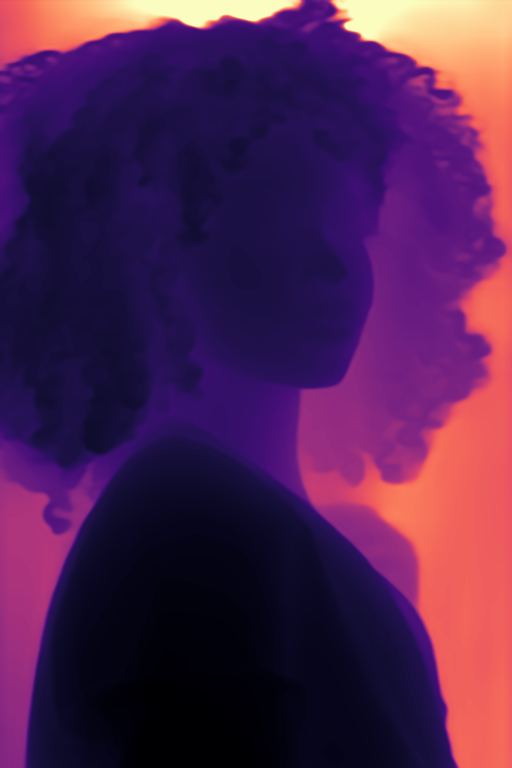

In [9]:
from PIL import Image
import requests

import torch
from transformers import AutoImageProcessor, ZoeDepthForDepthEstimation

image_processor = AutoImageProcessor.from_pretrained("Intel/zoedepth-nyu")
model = ZoeDepthForDepthEstimation.from_pretrained("Intel/zoedepth-nyu")

# prepare image for the model
url = "https://shariqfarooq-zoedepth.hf.space/file=/home/user/app/examples/person_1.jpeg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    outputs_flip = model(pixel_values=torch.flip(inputs.pixel_values, dims=[3]))

processed_output = post_process_depth_estimation_zoedepth(
    outputs, [image.size[::-1]], outputs_flip=outputs_flip, cmap="magma"
)[0]

print("Input image size (h, w):", image.size[::-1])
print("Output predicted depth shape (h, w):", processed_output["predicted_depth"].shape)
print("Output depth image size (h, w):", processed_output["depth"].size[::-1])
processed_output["depth"].resize((512, 768)).show()

## Render to Mesh

In [10]:
import numpy as np

def create_triangles(h, w, mask=None):
    # Source (modified): https://huggingface.co/spaces/shariqfarooq/ZoeDepth/blob/main/gradio_im_to_3d.py
    """Creates mesh triangle indices from a given pixel grid size.
        This function is not and need not be differentiable as triangle indices are
        fixed.
    Args:
    h: (int) denoting the height of the image.
    w: (int) denoting the width of the image.
    Returns:
    triangles: 2D numpy array of indices (int) with shape (2(W-1)(H-1) x 3)
    """
    x, y = np.meshgrid(range(w - 1), range(h - 1))
    tl = y * w + x
    tr = tl + 1
    bl = tl + w
    br = bl + 1
    triangles = np.array([tl, bl, tr, br, tr, bl]).flatten('F').reshape(-1, 3)
    # basically the same (but with different triplet order) as ▼
    # triangles = np.transpose(triangles, (1, 2, 0)).reshape(
    #     ((w - 1) * (h - 1) * 2, 3)
    # )
    if mask is not None:
        mask = mask.reshape(-1)
        triangles = triangles[mask[triangles].all(1)]

    return triangles

def get_intrinsics(H, W):
    """
    Intrinsics for a pinhole camera model.
    Assume fov of 55 degrees and central principal point.
    """
    f = 0.5 * W / np.tan(0.5 * 55 * np.pi / 180.0)
    cx = 0.5 * W
    cy = 0.5 * H
    return np.array([[f, 0, cx],
                     [0, f, cy],
                     [0, 0, 1]])

def depth_to_points(depth, R=None, t=None):
    K = get_intrinsics(depth.shape[1], depth.shape[2])
    Kinv = np.linalg.inv(K)
    if R is None:
        R = np.eye(3)
    if t is None:
        t = np.zeros(3)

    # M converts from your coordinate to PyTorch3D's coordinate system
    M = np.eye(3)
    M[0, 0] = -1.0
    M[1, 1] = -1.0

    height, width = depth.shape[1:3]

    x = np.arange(width)
    y = np.arange(height)
    coord = np.stack(np.meshgrid(x, y), -1)
    coord = np.concatenate((coord, np.ones_like(coord)[:, :, [0]]), -1)  # z=1
    coord = coord.astype(np.float32)
    # coord = torch.as_tensor(coord, dtype=torch.float32, device=device)
    coord = coord[None]  # bs, h, w, 3

    D = depth[:, :, :, None, None]
    # print(D.shape, Kinv[None, None, None, ...].shape, coord[:, :, :, :, None].shape )
    pts3D_1 = D * Kinv[None, None, None, ...] @ coord[:, :, :, :, None]
    # pts3D_1 live in your coordinate system. Convert them to Py3D's
    pts3D_1 = M[None, None, None, ...] @ pts3D_1
    # from reference to targe tviewpoint
    pts3D_2 = R[None, None, None, ...] @ pts3D_1 + t[None, None, None, :, None]
    # pts3D_2 = pts3D_1
    # depth_2 = pts3D_2[:, :, :, 2, :]  # b,1,h,w
    return pts3D_2[:, :, :, :3, 0][0]

In [11]:
import trimesh
import numpy as np
from transformers import AutoImageProcessor, ZoeDepthForDepthEstimation

def depth_edges_mask(depth):
    """Returns a mask of edges in the depth map.
    Args:
    depth: 2D numpy array of shape (H, W) with dtype float32.
    Returns:
    mask: 2D numpy array of shape (H, W) with dtype bool.
    """
    # Compute the x and y gradients of the depth map.
    depth_dx, depth_dy = np.gradient(depth)
    # Compute the gradient magnitude.
    depth_grad = np.sqrt(depth_dx ** 2 + depth_dy ** 2)
    # Compute the edge mask.
    mask = depth_grad > 0.04
    return mask

image_processor = AutoImageProcessor.from_pretrained("Intel/zoedepth-nyu")
model = ZoeDepthForDepthEstimation.from_pretrained("Intel/zoedepth-nyu")

@torch.inference_mode
def predict_depth(image):
    inputs = image_processor(images=image, return_tensors="pt")

    outputs = model(**inputs)
    outputs_flip = model(pixel_values=torch.flip(inputs.pixel_values, dims=[3]))

    return post_process_depth_estimation_zoedepth(
            outputs, [image.size[::-1]], outputs_flip=outputs_flip
        )[0]["predicted_depth"]

def get_mesh(image, keep_edges=False):
    depth = predict_depth(image)
    pts3d = depth_to_points(depth[None])
    pts3d = pts3d.reshape(-1, 3)

    # Create a trimesh mesh from the points
    # Each pixel is connected to its 4 neighbors
    # colors are the RGB values of the image

    verts = pts3d.reshape(-1, 3)
    image = np.array(image)
    if keep_edges:
        triangles = create_triangles(image.shape[0], image.shape[1])
    else:
        triangles = create_triangles(image.shape[0], image.shape[1], mask=~depth_edges_mask(depth))
    colors = image.reshape(-1, 3)
    mesh = trimesh.Trimesh(vertices=verts, faces=triangles, vertex_colors=colors)
    return mesh
    # # Save as glb
    # glb_file = tempfile.NamedTemporaryFile(suffix='.glb', delete=False)
    # glb_path = glb_file.name
    # mesh.export(glb_path)
    # return glb_path

In [12]:
from PIL import Image
import requests

url = "https://shariqfarooq-zoedepth.hf.space/file=/home/user/app/examples/ancient-carved.jpeg"
image = Image.open(requests.get(url, stream=True).raw)

mesh = get_mesh(image, keep_edges=False)

In [ ]:
mesh.show()